In [ ]:
import sys
import os
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import gseapy as gp
import decoupler as dc
import scanpy as sc

# Append the src directory to the path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

working_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/male"

In [2]:
from deg import *

In [19]:
adata_with_labels_file = '/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/scANVI_v2.h5ad'
#adata_with_features_file = 
adata = sc.read_h5ad(adata_with_labels_file)

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [20]:
adata

AnnData object with n_obs × n_vars = 87916 × 4000
    obs: 'sample_id', 'cell_type', 'condition', 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_mt_cb', 'log1p_total_counts_mt_cb', 'pct_counts_mt_cb', 'total_counts_ribo_cb', 'log1p_total_counts_ribo_cb', 'pct_counts_ribo_cb', 'total_counts_hb_cb', 'log1p_total_counts_hb_cb', 'pct_counts_hb_cb', 'n_genes', 'sex', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'hb', 'ribo', 'mt', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'C_scANVI_colors', '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'cell_type_colo

In [21]:
female_adata = adata[adata.obs['sex'] == 'F']
male_adata = adata[adata.obs['sex'] == 'M']

In [ ]:
# create a new obs for sex (take the first letter of the orig.ident)
#adata.obs['sex'] = adata.obs['orig.ident'].str[0]

In [ ]:
# cell_type_colors = {
#     'Fast IIB': '#FF9999',      # Light red/salmon
#     'Fast IIX': '#99C2FF',      # Light blue
#     'FAPs': '#99FFAB',          # Light green
#     'EC': '#E5B3FF',            # Light purple
#     'MTJ': '#FFB366',           # Light orange
#     'Pericyte': '#FFE4B5',      # Gold
#     'Skeleton MuSc': '#D4B499',  # Light brown
#     'NMJ': '#FFB3D9',           # Light pink
#     'Tendon': '#B3E6E6',        # Light cyan
#     'Macrophages': '#CCCCCC'    # Light gray
# }
# condition_colors = {
#     'WT': '#FFDAB9', # peachpuff
#     'KO': '#008080'     # Teal (darker)
# }
# sex_colors = {
#     'F': '#FFE4B5',   
#     'M': '#B8860B'    
# }

In [ ]:
# # Add the colors to adata
# adata.uns['cell_type_colors'] = [cell_type_colors[cell_type] for cell_type in adata.obs['cell_type'].cat.categories]
# adata.uns['condition_colors'] = [condition_colors[cond] for cond in adata.obs['condition'].cat.categories]
# adata.uns['sex_colors'] = [sex_colors[sex] for sex in adata.obs['sex'].cat.categories]

<Axes: title={'center': 'C_scANVI'}, xlabel='UMAP1', ylabel='UMAP2'>

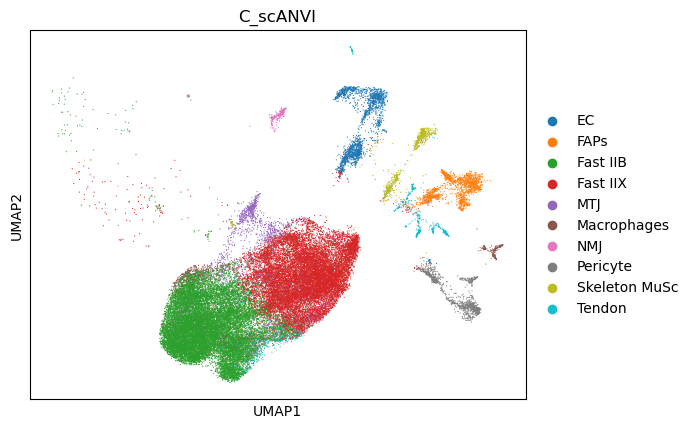

In [49]:
sc.pl.umap(male_adata, color=['C_scANVI'], show=False)

In [24]:
# get counts of obs C_scANVI
print(female_adata.obs['C_scANVI'].value_counts())
print(male_adata.obs['C_scANVI'].value_counts())


C_scANVI
Fast IIX         18391
Fast IIB         16189
MTJ               1951
EC                1650
FAPs              1126
Skeleton MuSc     1059
Pericyte           961
NMJ                785
Tendon             588
Macrophages        428
Name: count, dtype: int64
C_scANVI
Fast IIB         18566
Fast IIX         16002
EC                1911
MTJ               1767
FAPs              1609
Pericyte          1396
Macrophages       1043
Skeleton MuSc      945
Tendon             898
NMJ                651
Name: count, dtype: int64


In [ ]:
sc.pl.umap(adata[adata.obs['condition'] == 'KO'], color=['sex'], legend_loc='on data', show=False, title='Δ ERCC1 KO cells')

In [ ]:
sc.pl.umap(adata[adata.obs['condition'] == 'WT'], color=['sex'], legend_loc='on data', show=False, title='WT cells')

# Cell population depletion/expansion analysis

#### Cells pooled from both sexes

In [50]:
results_df = get_cell_type_percentages(male_adata, cell_type_label='C_scANVI')
results_df_by_sex = get_cell_type_percentages_by_sex(adata, cell_type_label='C_scANVI')


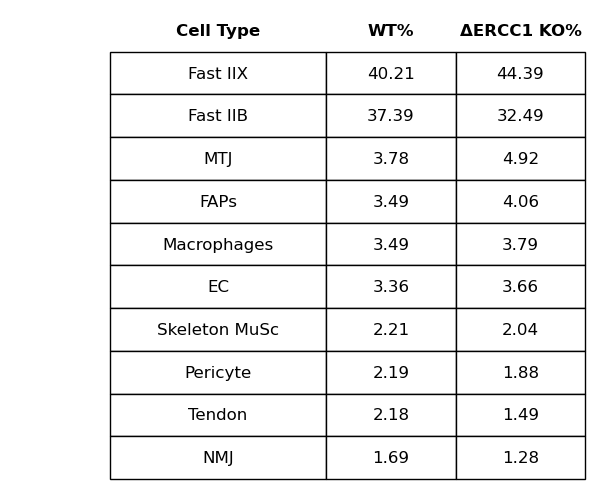

In [51]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))
ax.axis('off')

# Create table with more space on the left
table = ax.table(cellText=results_df.values,
                colLabels=results_df.columns,
                cellLoc='center',
                loc='center',
                bbox=[0.2, 0, 0.95, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
# Make headers bold and remove their edges
for col in range(len(results_df.columns)):
    header_cell = table[(0, col)]
    header_cell.set_text_props(weight='bold')
    header_cell.set_edgecolor('none')  # Remove cell borders for headers
    header_cell.set_facecolor('none')  # Remove cell background for headers
# Reduce row height and column width
for cell in table._cells:
    table._cells[cell].set_height(0.05)
    if cell[1] in [1, 2]:
        table._cells[cell].set_width(0.15)
    else:
        table._cells[cell].set_width(0.25)

# # Add colored dots with correct y-positions
# num_rows = len(results_df)
# for idx in range(num_rows):
#     cell_type = results_df['Cell Type'].iloc[idx]
    
#     # Calculate y position from top to bottom
#     y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
#     ax.scatter(0.23,
#               y_pos,
#               c=[C_scANVI_colors.get(cell_type, 'black')],
#               s=100,
#               clip_on=False,
#               zorder=1000)

# Set the plot limits explicitly to show the dots
ax.set_xlim(0.1, 1)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
# # Create figure and axis
# fig, ax = plt.subplots(figsize=(10, 5))  # Made wider to accommodate more columns
# ax.axis('off')
# # Create table with more space on the left
# table = ax.table(cellText=results_df_by_sex.values,
#                 colLabels=results_df_by_sex.columns,
#                 cellLoc='center',
#                 loc='center',
#                 bbox=[0.2, 0, 0.95, 1])

# # Style the table
# table.auto_set_font_size(False)
# table.set_fontsize(12)

# # Make headers bold
# for col in range(len(results_df_by_sex.columns)):
#     header_cell = table[(0, col)]
#     header_cell.set_text_props(weight='bold')
#     header_cell.set_edgecolor('none')  # Remove cell borders for headers
#     header_cell.set_facecolor('none')  # Remove cell background for headers

# # Reduce row height and adjust column widths
# # Reduce row height and column width
# for cell in table._cells:
#     table._cells[cell].set_height(0.05)
#     if cell[1] in [1, 2, 3, 4]:
#         table._cells[cell].set_width(0.15)
#     else:
#         table._cells[cell].set_width(0.25)

# # Add colored dots
# num_rows = len(results_df_by_sex)
# for idx in range(num_rows):
#     cell_type = results_df_by_sex['Cell Type'].iloc[idx]
#     y_pos = 1 - ((idx + 1.5) / (num_rows + 1))
    
#     ax.scatter(0.23,
#               y_pos,
#               c=[cell_type_colors.get(cell_type, 'black')],
#               s=100,
#               clip_on=False,
#               zorder=1000)

# ax.set_xlim(0.1, 1)
# ax.set_ylim(0, 1)
# plt.tight_layout()
# plt.show()

# [Analysis] Get the DEGs

In [28]:
# Set scanpy settings
sc.settings.verbosity = 1
sc.settings.figdir = working_dir

## Cell type specific analysis

In [ ]:
### DDR genes 
dna_damage_response = ['Atr', 'Atm', 'Chek1', 'Chek2', 'Trp53', 'Mdm2', 'Cdkn1a', 'Brca1', 'Brca2', 'Rad51', 'Xrcc6', 'Prkdc', 'Parp1', 'Xrcc1', 'Fancd2']

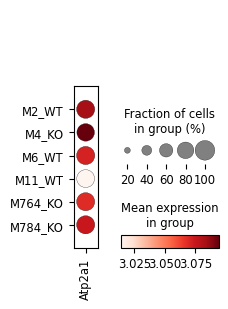

In [52]:
# check expression of Atp2a1 per sample dotplot
sc.pl.dotplot(
    male_adata,
    var_names=["Atp2a1"],
    groupby="sample_id"
)

In [53]:
# Run DEG analysis: KO vs WT for each cell type
cell_types = male_adata.obs['C_scANVI'].cat.categories
ko_wt_results = {}

for cell_type in cell_types:
    print(f"\nAnalyzing {cell_type}...")
    
    # Subset to specific cell type
    adata_subset = male_adata[male_adata.obs['C_scANVI'] == cell_type].copy()
    
    # Check sample sizes
    condition_counts = adata_subset.obs['condition'].value_counts()
    print(f"  Cells per condition: {condition_counts.to_dict()}")
    
    # Check if both KO and WT exist
    if 'KO' in condition_counts.index and 'WT' in condition_counts.index:
        if condition_counts['KO'] >= 10 and condition_counts['WT'] >= 10:  # Minimum cell threshold
            
            # Run differential expression
            sc.tl.rank_genes_groups(
                adata_subset,
                groupby='condition',
                groups=['KO'],
                reference='WT',
                method='wilcoxon',
                use_raw=False,
                pts=True,  # Calculate percent expressed
                key_added='KO_vs_WT'
            )
            
            # Extract results
            degs = sc.get.rank_genes_groups_df(adata_subset, group='KO', key='KO_vs_WT')
            
            # Add cell type column
            degs['cell_type'] = cell_type
            
            # Store results
            ko_wt_results[cell_type] = degs
            
            # Count significant genes
            sig_up = ((degs['pvals_adj'] < 0.05) & (degs['logfoldchanges'] > 0.5)).sum()
            sig_down = ((degs['pvals_adj'] < 0.05) & (degs['logfoldchanges'] < -0.5)).sum()
            print(f"  Significant DEGs: {sig_up} upregulated, {sig_down} downregulated")
            
            # Save individual file
            degs.to_csv(os.path.join(working_dir, f"DEGs_KO_vs_WT_{cell_type.replace(' ', '_').replace('/', '_')}.csv"), index=False)
        else:
            print(f"  Skipping - insufficient cells")
    else:
        print(f"  Skipping - missing KO or WT samples")

# Print summary table
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
for ct, degs in ko_wt_results.items():
    sig = degs['pvals_adj'] < 0.05
    up = (sig & (degs['logfoldchanges'] > 0.5)).sum()
    down = (sig & (degs['logfoldchanges'] < -0.5)).sum()
    print(f"{ct:20s} | ↑ {up:4d} | ↓ {down:4d} | Total: {len(degs):5d}")


Analyzing EC...
  Cells per condition: {'KO': 1280, 'WT': 631}
  Significant DEGs: 1 upregulated, 0 downregulated

Analyzing FAPs...
  Cells per condition: {'KO': 953, 'WT': 656}
  Significant DEGs: 16 upregulated, 5 downregulated

Analyzing Fast IIB...
  Cells per condition: {'KO': 11548, 'WT': 7018}
  Significant DEGs: 19 upregulated, 39 downregulated

Analyzing Fast IIX...
  Cells per condition: {'KO': 8454, 'WT': 7548}
  Significant DEGs: 22 upregulated, 14 downregulated

Analyzing MTJ...
  Cells per condition: {'KO': 1057, 'WT': 710}
  Significant DEGs: 6 upregulated, 10 downregulated

Analyzing Macrophages...
  Cells per condition: {'WT': 656, 'KO': 387}
  Significant DEGs: 37 upregulated, 46 downregulated

Analyzing NMJ...
  Cells per condition: {'KO': 334, 'WT': 317}
  Significant DEGs: 5 upregulated, 5 downregulated

Analyzing Pericyte...
  Cells per condition: {'KO': 985, 'WT': 411}
  Significant DEGs: 19 upregulated, 4 downregulated

Analyzing Skeleton MuSc...
  Cells per c


Generating volcano plots...

Creating plot for EC...


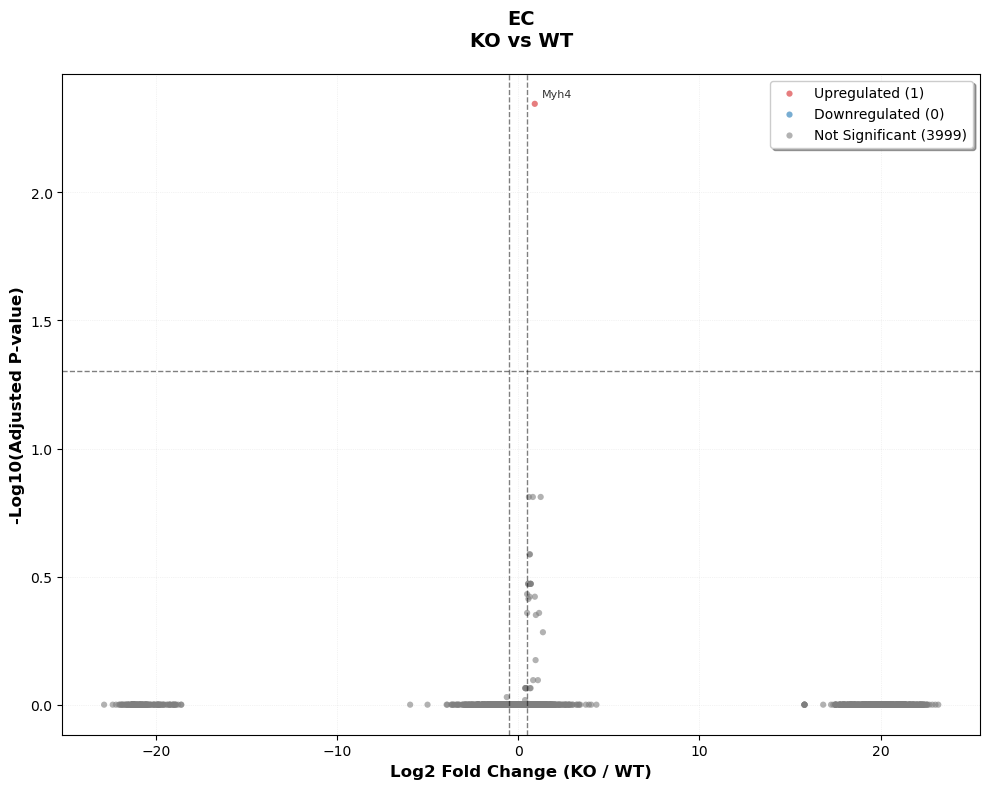


Creating plot for FAPs...


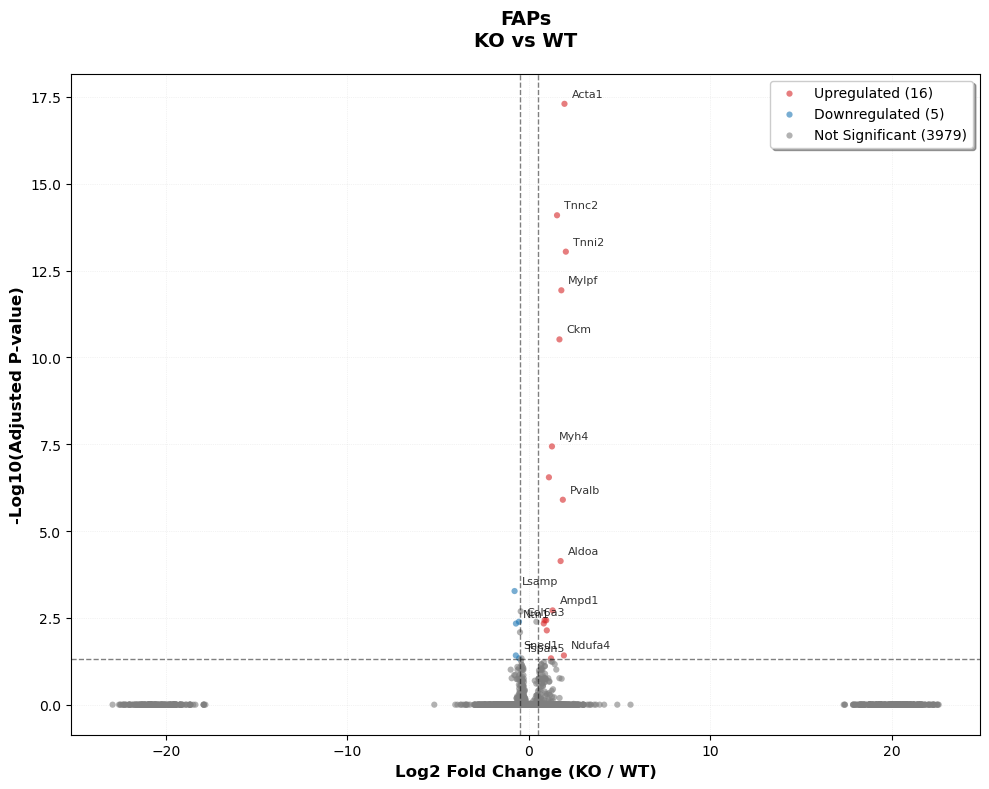


Creating plot for Fast IIB...


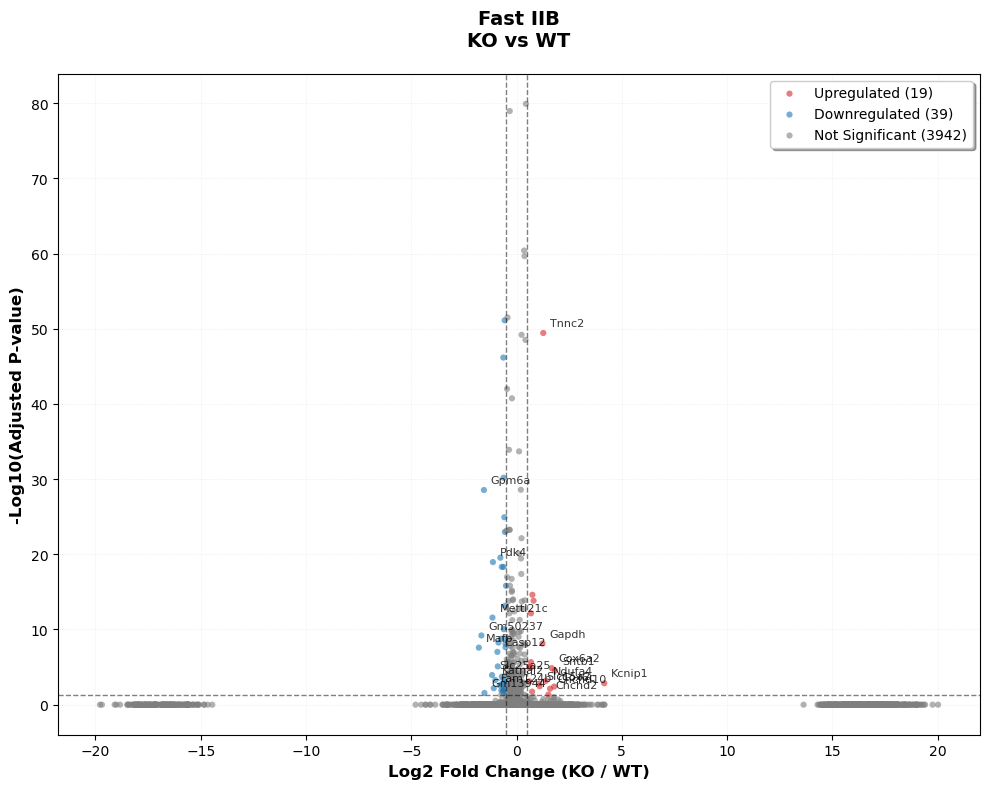


Creating plot for Fast IIX...


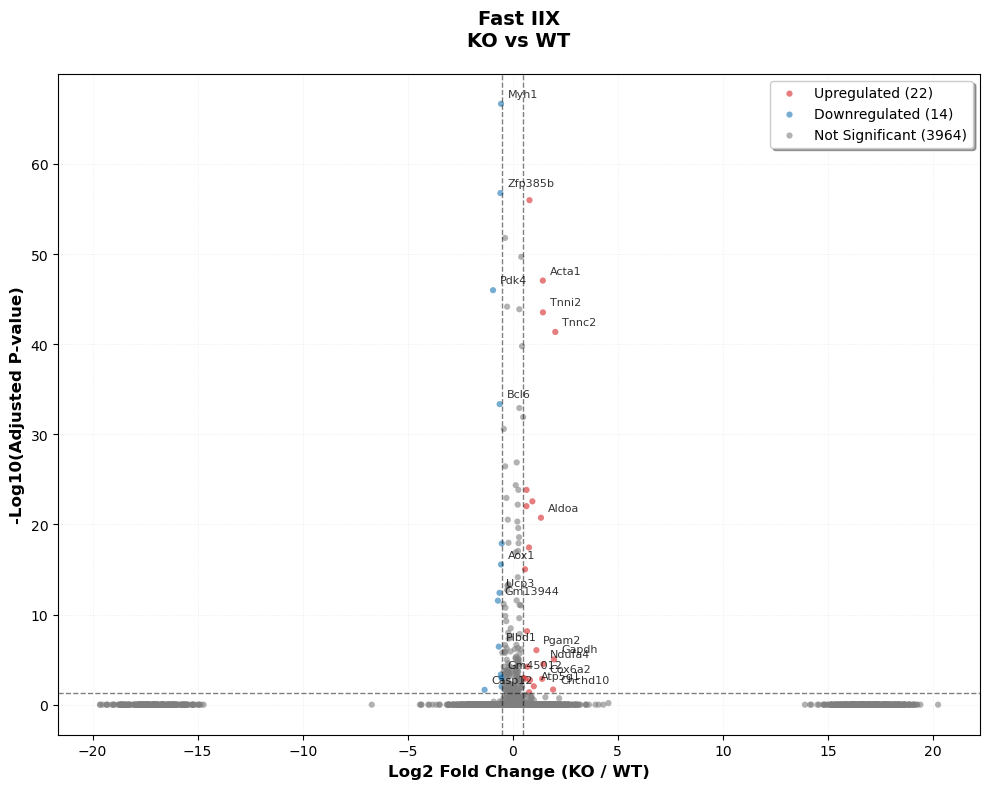


Creating plot for MTJ...


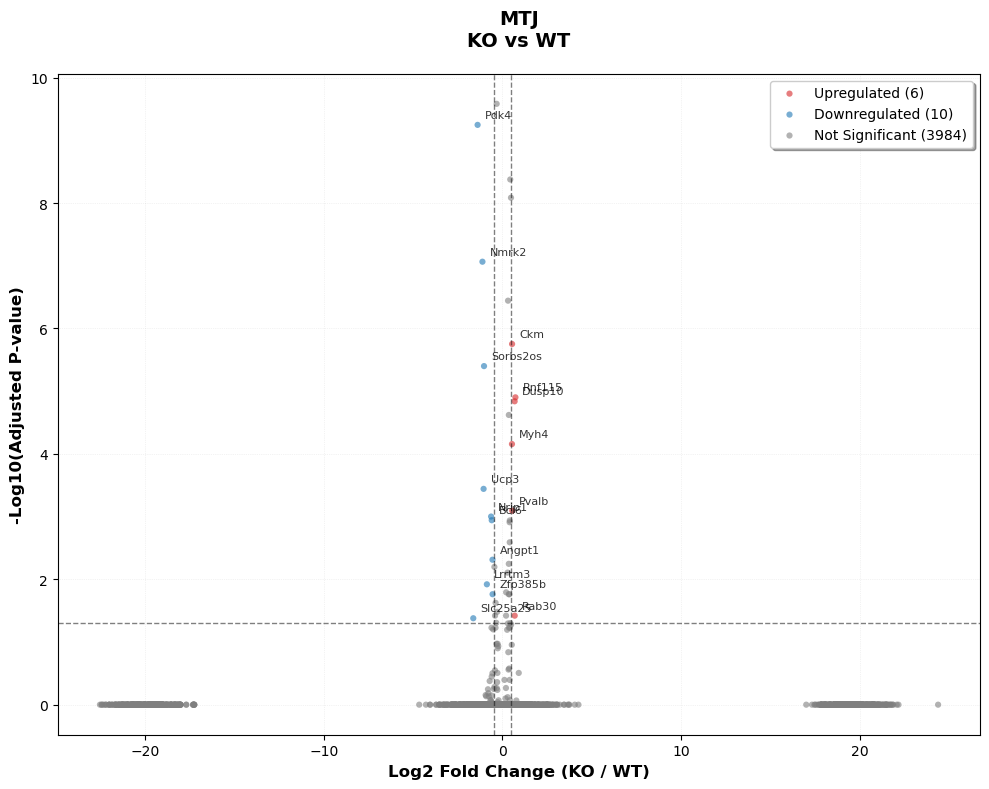


Creating plot for Macrophages...


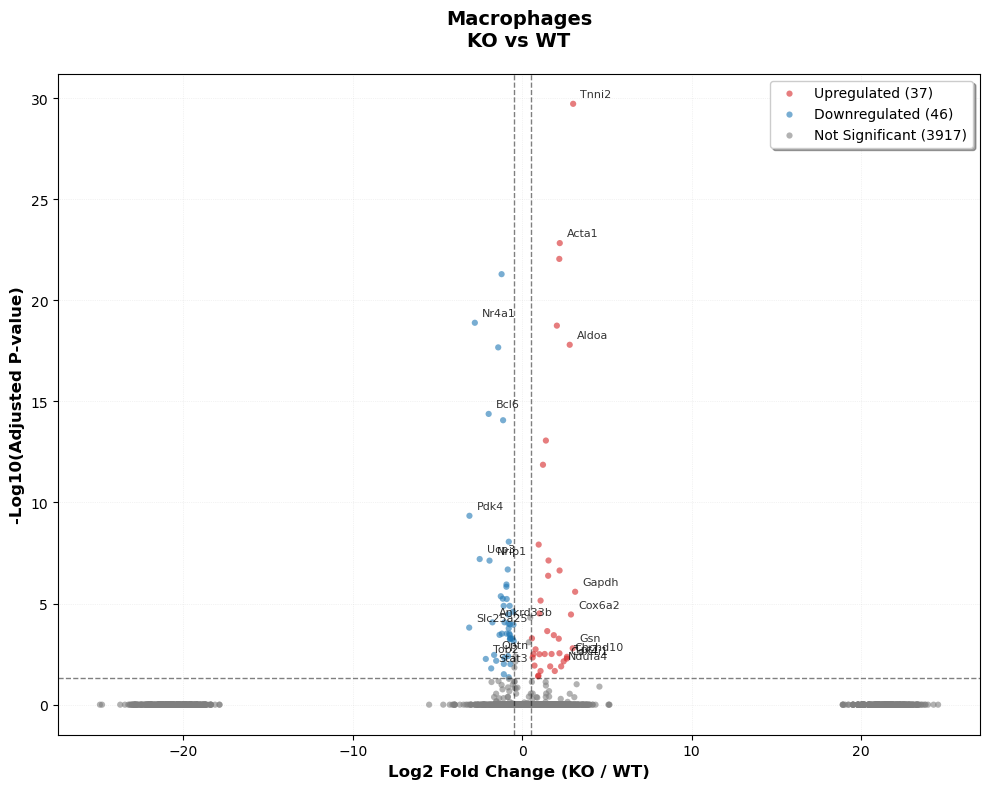


Creating plot for NMJ...


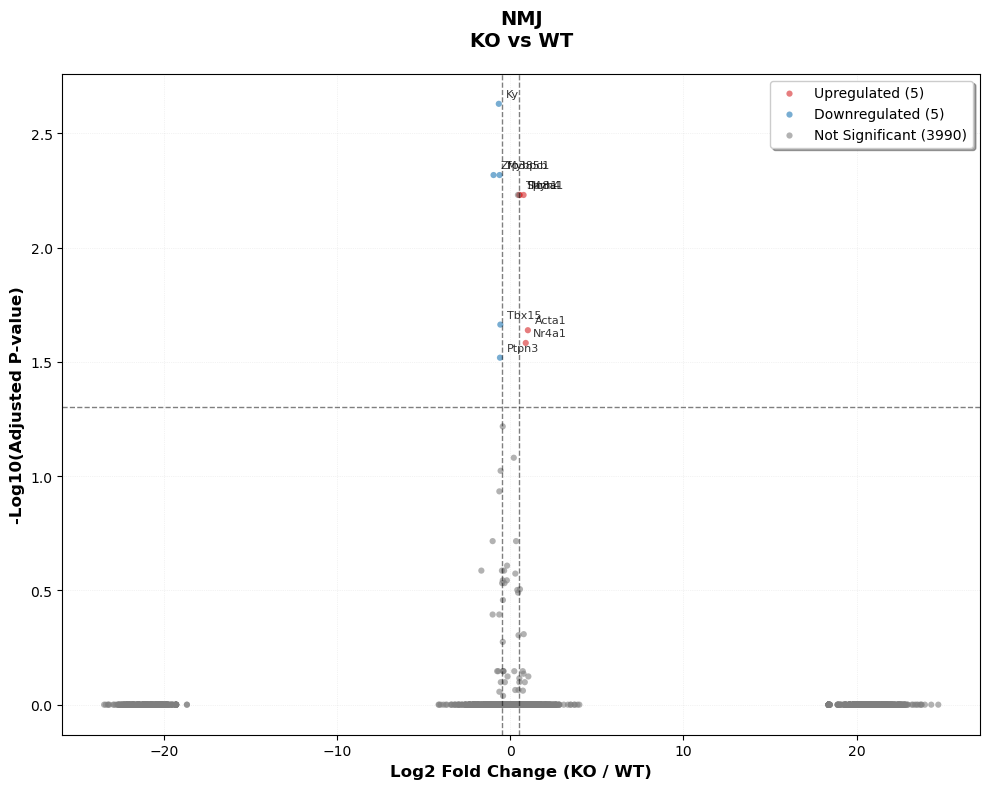


Creating plot for Pericyte...


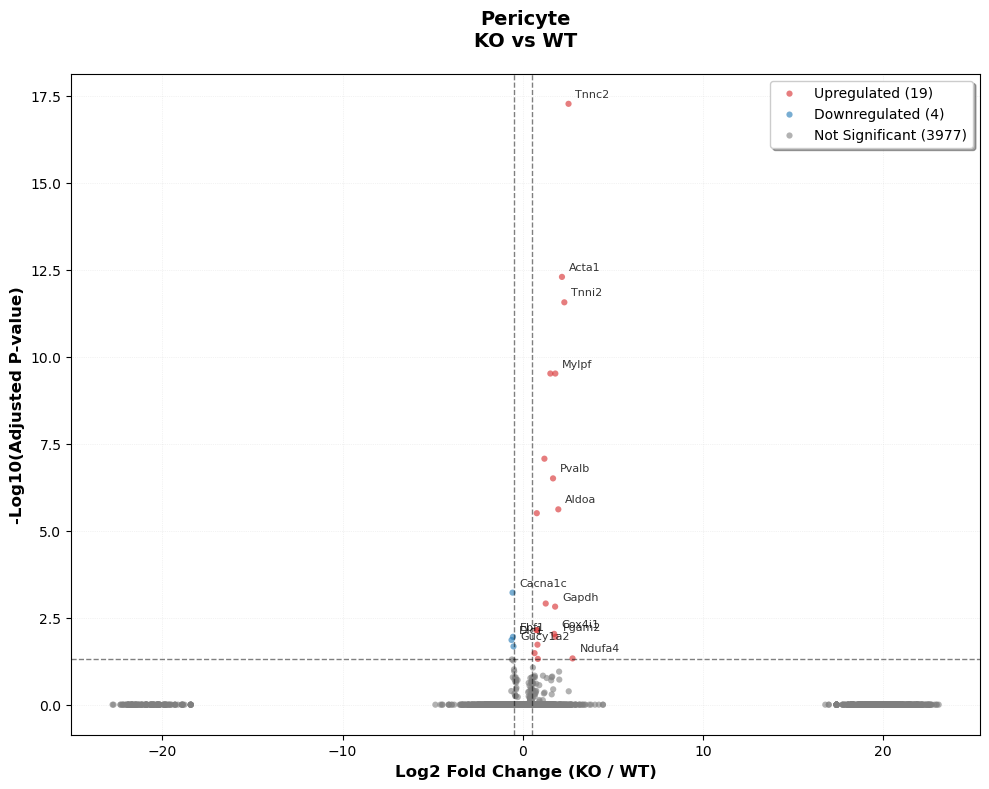


Creating plot for Skeleton MuSc...


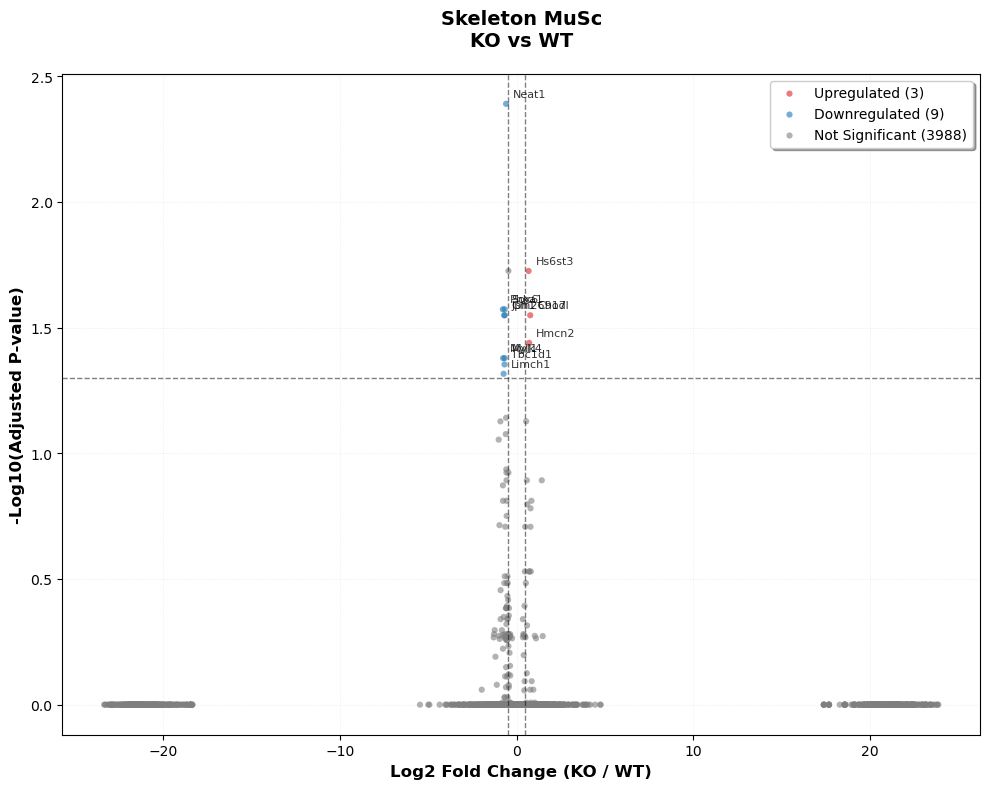


Creating plot for Tendon...


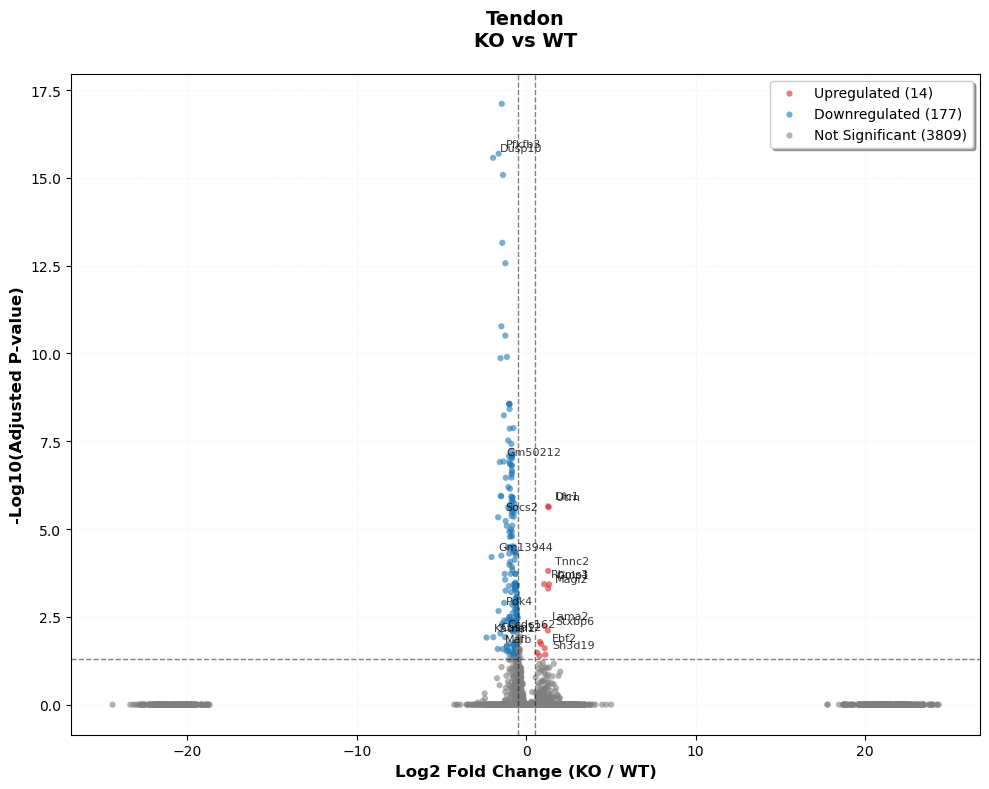


✓ All volcano plots generated!


In [54]:
# Generate volcano plots for all cell types
print("\nGenerating volcano plots...")
print("="*60)

for cell_type, degs in ko_wt_results.items():
    print(f"\nCreating plot for {cell_type}...")
    create_volcano_plot(degs, cell_type, top_n=10, save=False)

print("\n✓ All volcano plots generated!")

## Load pre-calculated DEGs

In [57]:
########## file paths ##########
output_dir = "/ocean/projects/cis240075p/asachan/datasets/TA_muscle/ERCC1_KO_mice/integrated_samples/analysis/male"

all_fast2b_path = os.path.join(working_dir, "DEGs_KO_vs_WT_Fast_IIB.csv")

all_fast2x_path = os.path.join(working_dir, "DEGs_KO_vs_WT_Fast_IIX.csv")


In [58]:
# ############ load cell-type specific DEGs ############

all_fast2b_degs = pd.read_csv(all_fast2b_path, header=0)
all_fast2x_degs = pd.read_csv(all_fast2x_path, header=0)


In [59]:
gsea_all_fast2b_degs = create_ranked_genelist(all_fast2b_degs, log2fc_col='logfoldchanges', pval_col='pvals_adj', gene_col='names')
gsea_all_fast2x_degs = create_ranked_genelist(all_fast2x_degs, log2fc_col='logfoldchanges', pval_col='pvals_adj', gene_col='names')


In [60]:
display(gsea_all_fast2b_degs)

names,Tnnc2,Slc8a1,Pvalb,Ckm,Rbm20,Kcnip1,Tpm1,Aldoa,Tnni2,Gapdh,...,Ucp3,Gm50237,Nmrk2,Wwox,Pdk4,Atp8a1,Myl1,Mybpc1,Bcl6,Gpm6a
ranking_score,62.847998,35.539744,22.789318,21.854213,20.640467,11.868719,11.745435,11.198852,11.029073,10.046433,...,-14.993351,-15.371317,-18.574583,-18.886028,-21.26254,-21.979019,-25.411352,-28.814278,-28.94263,-44.205566


# Pathway analysis

In [61]:
# load msigDB all genesets for mice
msigdb_mice_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/msigdb.v2024.1.Mm.symbols.gmt"
mhallmark_gmt = "/ocean/projects/cis240075p/asachan/datasets/gene_sets/mouse/mh.all.v2024.1.Mm.symbols.gmt"

In [62]:
msigdb_mice = gmt_to_decoupler(msigdb_mice_gmt)
mhallmark = gmt_to_decoupler(mhallmark_gmt)
# Count unique genesets
n_unique_genesets = msigdb_mice['geneset'].nunique()
n_unique_genesets_mhallmark = mhallmark['geneset'].nunique()
print(f"Number of unique genesets: {n_unique_genesets}")
print(f"Number of unique genesets: {n_unique_genesets_mhallmark}")

Number of unique genesets: 16059
Number of unique genesets: 50


In [63]:
# Filtering genesets to match behaviour of fgsea
geneset_size = msigdb_mice.groupby("geneset").size()
geneset_size_mhallmark = mhallmark.groupby("geneset").size()
# Index object of genesets that have more than 15 and less than 500 genes
gsea_genesets = geneset_size.index[(geneset_size > 15) & (geneset_size < 500)]
gsea_genesets_mhallmark = geneset_size_mhallmark.index[(geneset_size_mhallmark > 15) & (geneset_size_mhallmark < 500)]

### Select Pathways related to mitochondrial function

In [ ]:
# Create a list of keywords you're interested in
keywords = [
    'OXIDATIVE_PHOSPHORYLATION',      # For oxidative phosphorylation
    'TCA',         # For TCA cycle
    'GLUTAMINE',   # For glutamine metabolism
    'CALCIUM',     # For calcium signaling
    'APOPTOSIS'    # For apoptosis
]

selected_pathways = [
    pathway for pathway in gsea_genesets
    if any(keyword.lower() in pathway.lower() for keyword in keywords)
]

display(len(selected_pathways))

In [ ]:
# find the geneset that contains the gene 'Atp2a1'
serca_genesets = []
for geneset in selected_pathways:
    if 'Atp2a1' in msigdb_mice[msigdb_mice['geneset'] == geneset]['genesymbol'].values:
        serca_genesets.append(geneset)
        break

display(serca_genesets)

#### Run gsea

In [67]:
scores, norm, pvals = dc.run_gsea(
    gsea_all_fast2x_degs,
    mhallmark,
    source="geneset",
    target="genesymbol",
)

gsea_results = (
    pd.concat({"score": scores.T, "norm": norm.T, "pval": pvals.T}, axis=1)
    .droplevel(level=1, axis=1)
    .sort_values("pval")
)
display(gsea_results.head())

,score,norm,pval
source,,,
HALLMARK_XENOBIOTIC_METABOLISM,-0.943491,-1.485693,0.031941
HALLMARK_MYOGENESIS,0.839240,1.405594,0.043818
HALLMARK_KRAS_SIGNALING_DN,0.910964,1.337845,0.093913
HALLMARK_APICAL_JUNCTION,0.917255,1.316419,0.096257
HALLMARK_IL2_STAT5_SIGNALING,-0.910315,-1.350034,0.102871


In [68]:
# First prepare your data
# gsea_results = gsea_results[~gsea_results.index.str.startswith('WP')]
gsea_results['-log10(pval)'] = -np.log10(gsea_results['pval'].replace(0, 1e-300))
gsea_results['Group'] = gsea_results['score'].apply(lambda x: 'Up' if x > 0 else 'Down')
# Create a copy with reset index to get the pathway names as a column
plot_df = gsea_results.reset_index().copy()
plot_df[['Gene_set', 'Name']] = plot_df['source'].str.extract(r'(GOBP|REACTOME|KEGG|HALLMARK|GOMF|GOCC|GRAESSMANN|WP)_(.+)')
plot_df['Name'] = plot_df['Name'].apply(lambda x: '_'.join(x.split('_')[:6]))
plot_df = plot_df.loc[plot_df.groupby('Name')['-log10(pval)'].idxmax()]
# copy source column to a new column called 'Term'
plot_df['Term'] = plot_df['source']
display(plot_df.head())


,source,score,norm,pval,-log10(pval),Group,Gene_set,Name,Term
17,HALLMARK_ADIPOGENESIS,0.439269,0.650027,0.878788,0.056116,Up,HALLMARK,ADIPOGENESIS,HALLMARK_ADIPOGENESIS
15,HALLMARK_ANDROGEN_RESPONSE,0.607879,0.885876,0.667851,0.175321,Up,HALLMARK,ANDROGEN_RESPONSE,HALLMARK_ANDROGEN_RESPONSE
3,HALLMARK_APICAL_JUNCTION,0.917255,1.316419,0.096257,1.016569,Up,HALLMARK,APICAL_JUNCTION,HALLMARK_APICAL_JUNCTION
9,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,0.853167,1.215397,0.252560,0.597636,Up,HALLMARK,EPITHELIAL_MESENCHYMAL_TRANSITION,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION
16,HALLMARK_ESTROGEN_RESPONSE_EARLY,-0.425238,-0.654896,0.854460,0.068308,Down,HALLMARK,ESTROGEN_RESPONSE_EARLY,HALLMARK_ESTROGEN_RESPONSE_EARLY


### Plotting the enrichment results

In [42]:
from gseapy.scipalette import SciPalette
sci = SciPalette()
NbDr = sci.create_colormap()

/ocean/projects/cis240075p/asachan/.conda/envs/scproc/lib/python3.12/site-packages/gseapy/plot.py:753: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda _x: _x.sort_values(by=self.colname).tail(self.n_terms))


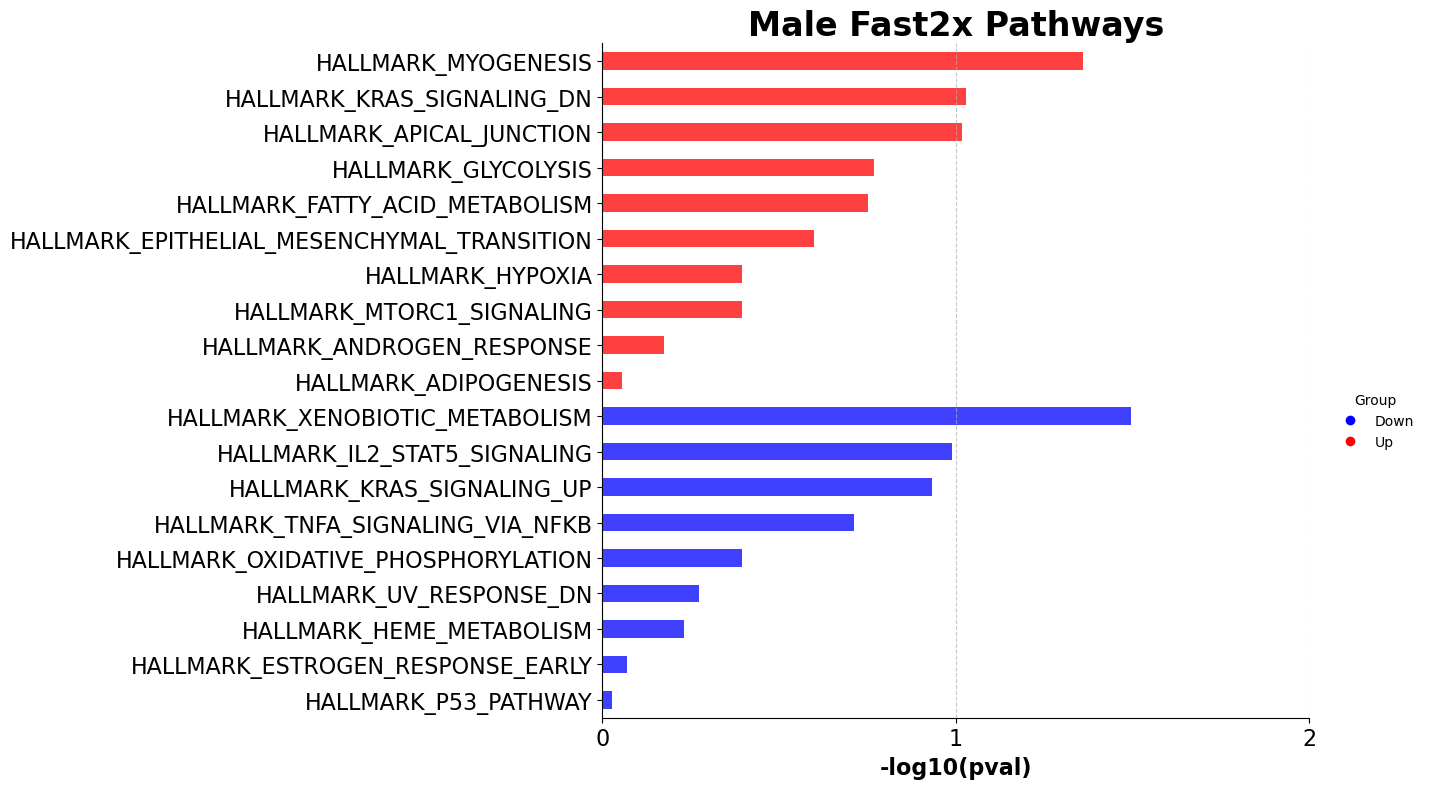

In [69]:
# Create simplified terms and group by them
plot_df['simple_term'] = plot_df['Term'].apply(simplify_term)
# Keep only the most significant pathway for each simplified term
plot_df = plot_df.loc[plot_df.groupby('simple_term')['-log10(pval)'].idxmax()]
# Sort to put Up group at top
plot_df = plot_df.sort_values(['Group', '-log10(pval)'], ascending=[True, False])

ax = gp.barplot(
    df=plot_df,
    column='-log10(pval)',
    group='Group',
    title='Male Fast2x Pathways',
    color={'Up': 'red', 'Down': 'blue'},
    cutoff=2.0,
    figsize=(14, 8)
)

# Set x-axis limits and ticks
ax.set_xlim(0, 2)  # Fixed limit to 2.5
ax.set_xticks([0, 1, 2])  # Only show 0, 1, and 2
ax.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.subplots_adjust(left=0.4)
plt.show()

In [ ]:
cutoff_for_plotting_data = plot_df[plot_df['-log10(pval)'] <= 2][['Term', 'Group', '-log10(pval)']]
top_paths = (cutoff_for_plotting_data.groupby('Group')
            .apply(lambda x: x.nlargest(min(10, len(x)), '-log10(pval)'))
            .reset_index(drop=True))

# Sort by Group (to keep Up on top) and then by -log10(pval)
top_paths = top_paths.sort_values(['Group', '-log10(pval)'], ascending=[True, False])
display(top_paths)
